In [1]:
import torch
import torch.nn as nn
from IPython.display import Image
import random

# [RNN](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html)

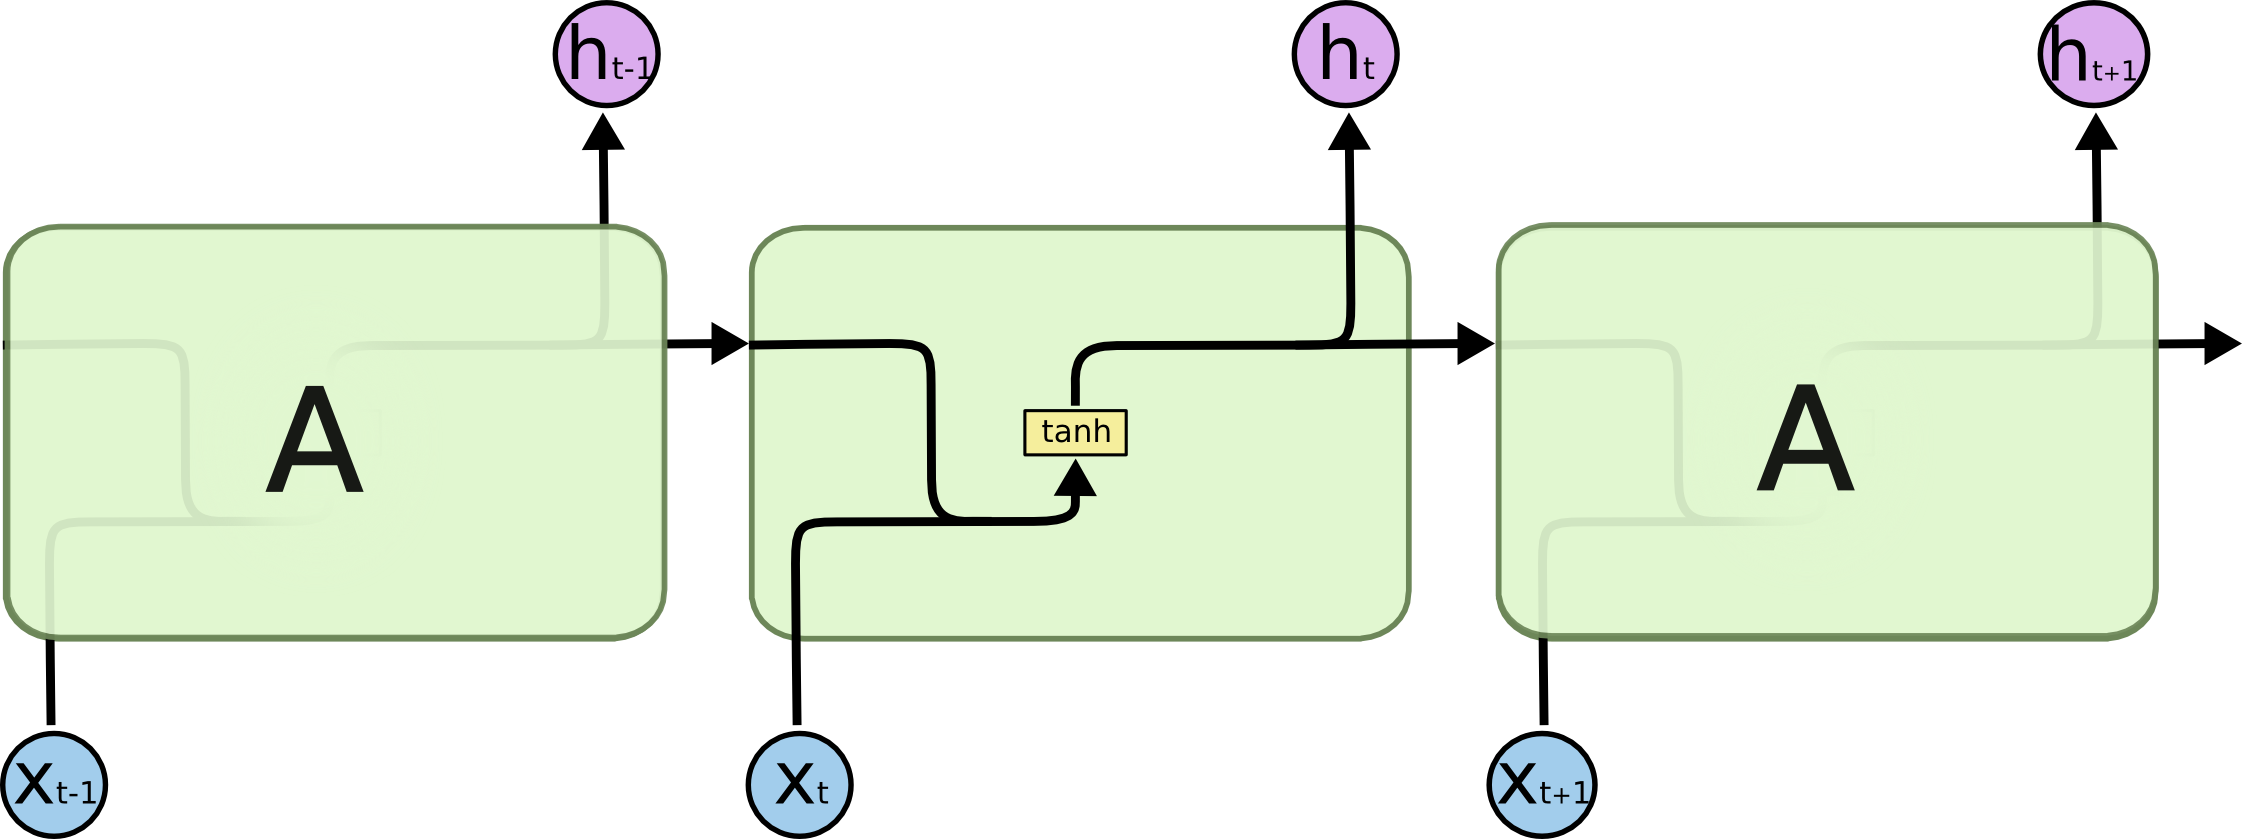

In [2]:
Image("images/rnn.png", width="80%")

`RNN` (Recurrent Neural Network) — это класс нейронных сетей, предназначенный для обработки последовательных данных.

`RNN` при обработке нового элемента (например, слова в предложении) учитывает контекст, полученный из предыдущих элементов.

Принцип работы `RNN` для одного слоя в одной формуле:

$$h_t^{(l)} = \tanh \left( W_{xh}^{(l)} \cdot x_t^{(l)} + b_x^{(l)} + W_{hh}^{(l)} \cdot h_{t-1}^{(l)} + b_h^{(l)} \right)$$

Где:

$h_t^{(l)}$ — скрытое состояние слоя $l$ в момент времени $t$. В коде это `h_next[layer]`.

$h_{t-1}^{(l)}$ — скрытое состояние слоя $l$ в момент времени $t-1$. В коде это `h[layer]`.

$x_t^{(l)}$ — вход для слоя $l$ в момент времени $t$. В коде это `x_t`.

- Если $l=0$, то $x_t^{(0)} = x_t$ (эмбеддинг токена). $\newline$

- Если $l>0$, то $x_t^{(l)} = h_t^{(l-1)}$ (скрытое состояние с предыдущего слоя). 

Пусть всего есть $L$ слоев (в коде `num_layers`). Тогда $l$ — это индекс текущего слоя, где $l \in [0, L-1]$. Для каждого слоя есть свой вектор скрытого состояния (в начальный момент времени часто инициализируются нулями). На вход `RNN` подается последовательность эмбеддингов. В самом простом случае для каждого эмбеддинга происходит прямой проход по всем слоям. Причем, для первого слоя в качестве входного вектора подается сам эмбеддинг, а для последующих слоев вектор скрытого состояния, полученный с выхода предыдущего слоя. Для `t=0` (первый эмбеддинг) происходит обновление вектора скрытого состояния $h_0^{(l)}$ до $h_1^{(l)}$ для каждого слоя, где $l \in [0, L-1]$. Для остальных эмбеддингов в последовательности та же логика.

$W_{xh}^{(l)}$ и $b_x^{(l)}$ — обучаемые матрица весов и смещение для входного вектора для слоя $l$.

$W_{hh}^{(l)}$ и $b_h^{(l)}$ — обучаемые матрица весов и смещение для вектора скрытого состояния для слоя $l$.

**Для чего нужны обучаемые параметры?**

- **Обучаемость**. Обучаемые матрицы и векторы, как ни странно, позволяют сделать `RNN` обучаемым. Без них модель не могла бы находить закономерности в данных. $\newline$

- **Приведение размерностей**. Вход $x_t^{(l)}$ может быть размером, например, 100, а скрытое состояние $h_{t-1}^{(l)}$ — размером 256. Чтобы их можно было сложить, нужно превратить $x_t^{(l)}$ и $h_{t-1}^{(l)}$ в вектор одного и того же размера 256. $\newline$

- **Обучаемое преобразование признаков**. Каждый нейрон в скрытом состоянии получает комбинацию всех входных признаков, но с разными весами. $W_{xh}^{(l)}$ "решает", какие части нового входа $x_t^{(l)}$ важны, а $W_{hh}^{(l)}$ "решает", какие части прошлой памяти $h_{t-1}^{(l)}$ стоит учесть для текущего шага.

### Хорошие источники для понимания

**[ссылка](https://www.youtube.com/watch?v=3OljkWQ2Uc0); [ссылка](https://www.youtube.com/watch?v=WsXgPD4lmlc&t=361s); [ссылка](https://www.youtube.com/watch?v=OF_JnQlHXQ4); [ссылка](https://colah.github.io/posts/2015-08-Understanding-LSTMs/); [ссылка](https://www.youtube.com/watch?v=2a_7SmTNrJA)**

## Пример работы `RNN` и его скрытые состояния в каждый момент времени

<font size="3">По оси $x$ представлены слои, по оси $y$ — время $t$ (подаются эмбеддинги последовательно).</font>

<font size="3">На рисунке $h_{\,l}^{t}$ — скрытое состояние в момент времени $t$ для слоя $l$, где $t∈[0, T];$ $l∈[1, n]$</font>

<font size="3">Для этого рисунка:</font>

$h_{\,l}^{t} = \tanh \,(\, ... )$

$y_{\,l}^{\,t}=h_{\,l}^{t}$

<font size="3">Важно уточнить, что в пределах одного слоя используются одни и те же матрицы весов и смещении для каждого момента времени $t$, так как это все еще прямой проход модели.</font>

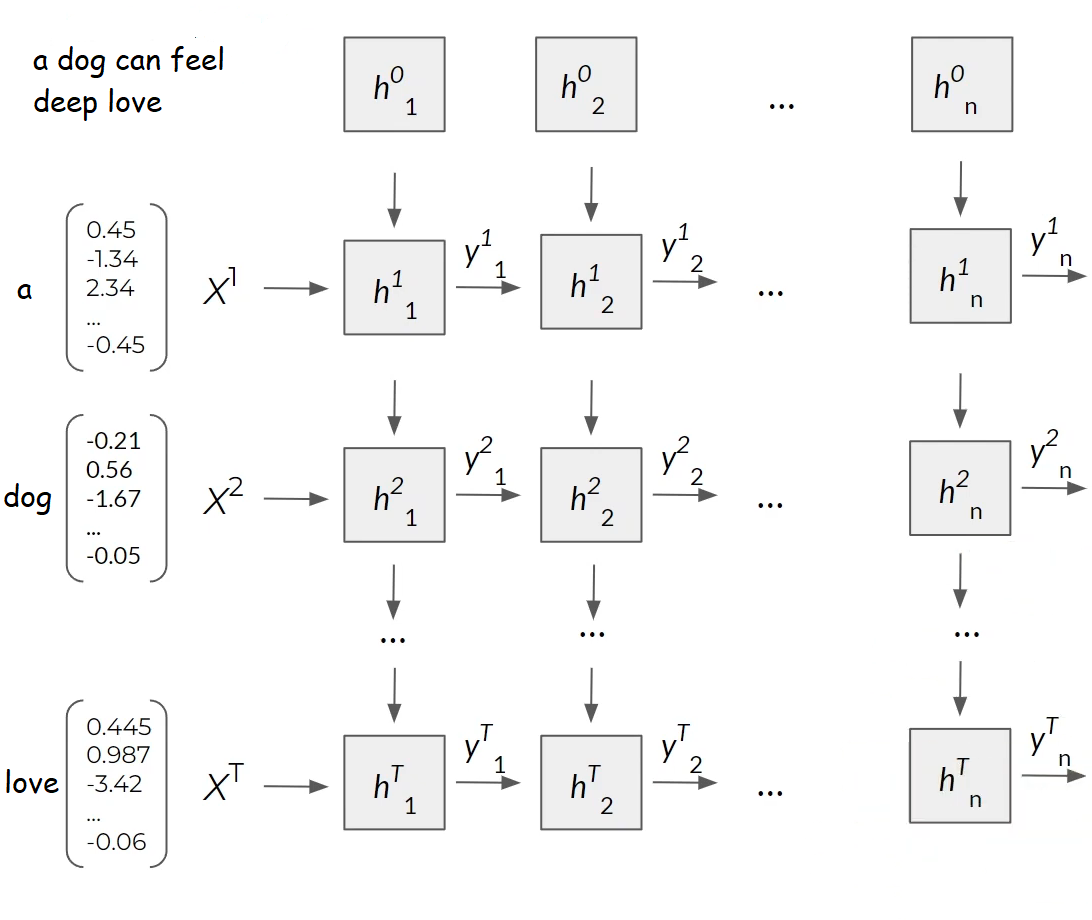

In [3]:
Image("images/rnn_operation.png", width="70%")

## Пример реализации `RNN`

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size    # Размерность входного вектора x_t
        self.hidden_size = hidden_size  # Размер скрытого состояния h_t
        self.num_layers = num_layers    # Количество рекуррентных слоёв
        
        # Список линейных слоёв для входов (W_xh)
        # Первый слой: input_size → hidden_size
        # Остальные слои: hidden_size → hidden_size
        self.input_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size) if i == 0 else nn.Linear(hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        # Список линейных слоёв для скрытых состояний (W_hh)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        """
        x: [batch, seq_len, input_size]
        """
        device = x.device
        x = x.transpose(0, 1)              # [seq_len, batch, input_size]
        seq_len, batch_size, _ = x.size()
        
        # Инициализация скрытого состояния нулями: [num_layers, batch_size, hidden_size]
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        
        out = []                           # Список для хранения выходов всех временных шагов
        for t in range(seq_len):
            h_next = []                    # Список для скрытых состояний текущего шага
            for layer in range(self.num_layers):
                x_t = x[t] if layer == 0 else h_next[layer-1]
                h_next.append(torch.tanh(
                    self.input_layers[layer](x_t)
                    + self.hidden_layers[layer](h[layer])
                ))
            h = torch.stack(h_next)        # Обновляем скрытые состояния всех слоёв
            out.append(h[-1].clone())      # Сохраняем выход последнего слоя для текущего шага
            
        out = torch.stack(out)             # [seq_len, batch, hidden_size]
        out = out.transpose(0, 1)          # [batch, seq_len, hidden_size]
        
        return out, h

## Проблема RNN

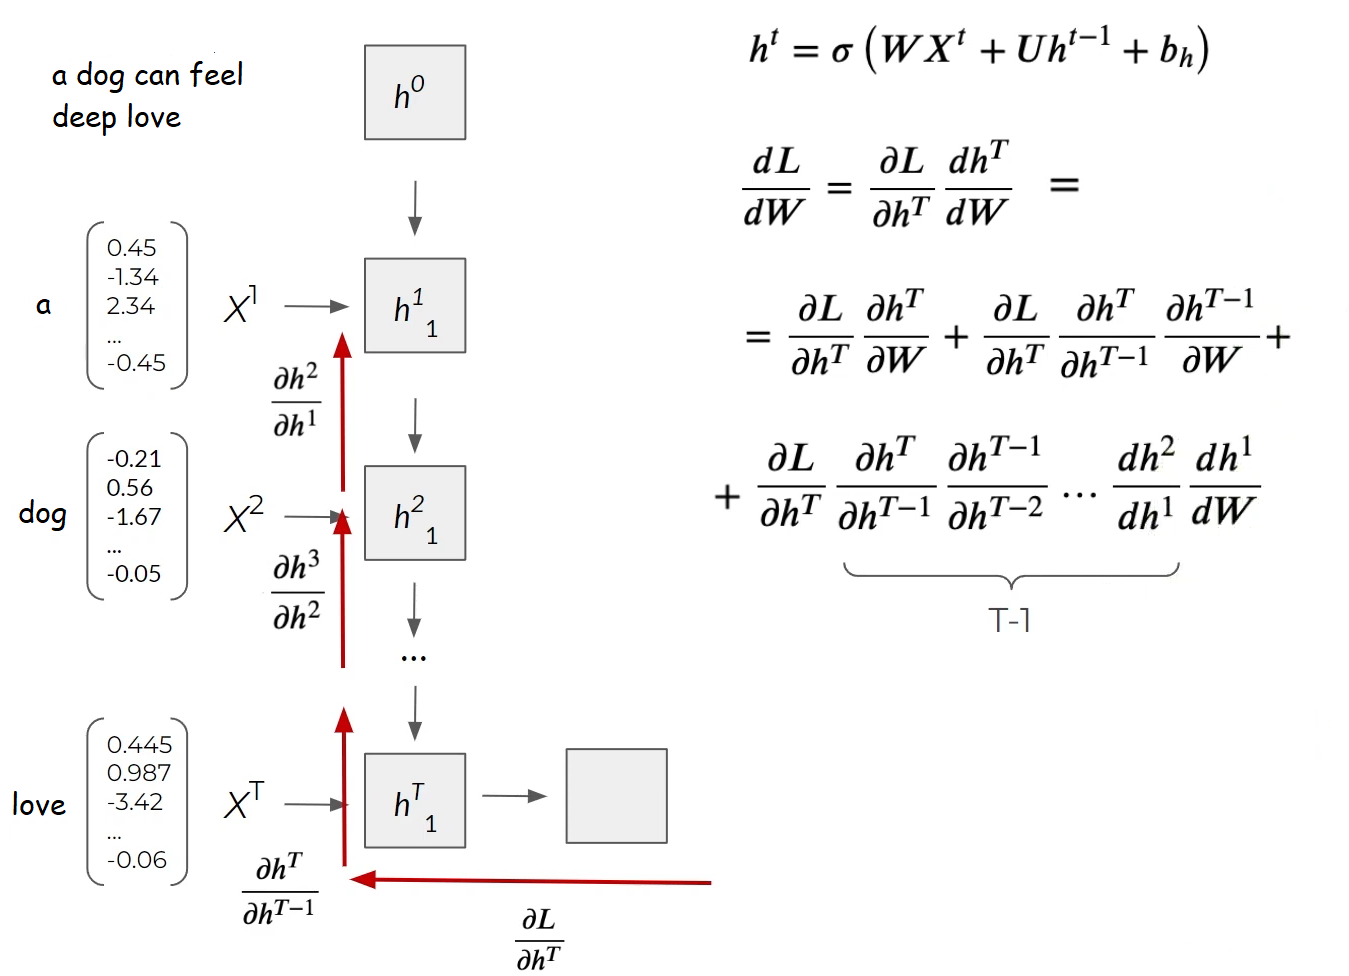

In [5]:
Image("images/rnn_problem.png", width="70%")

<font size="3">Как видно из рисунка выше, производная $\frac{dL}{dW}$ имеет столько слагаемых, какова длина подаваемой последовательности. Видно, что слагаемые, которые отвечают за последние данные (эмбеддинги) последовательности, имеют меньше множителей, а слагаемые, которые отвечают за начальные данные последовательности, имеют больше множителей в произведении.</font>

<font size="3">Чем больше множителей в произведении, тем выше шанс возникновения ситуации взрывающихся или затухающих градиентов. Например, если каждый множитель меньше 1, то перемножение большого числа таких множителей приведет к проблеме затухающих градиентов, в таком случае фактически в обучении модели будут участвовать только последние слагаемые производной.</font>

### Функции активации в RNN

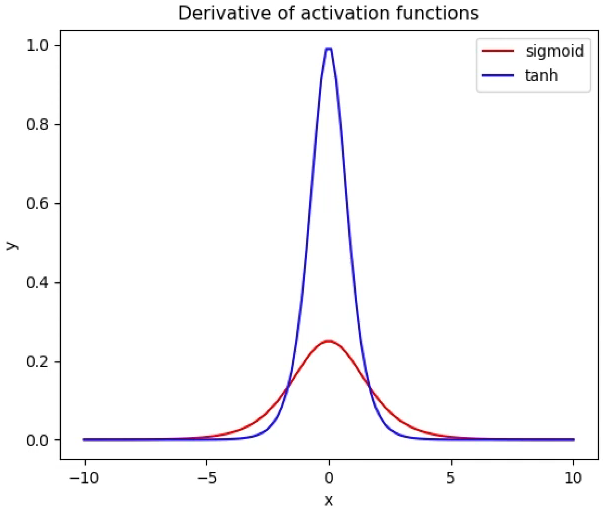

In [6]:
Image("images/sigm_tanh_df.png", width="50%")

- <font size="3">Если используется функция активации Sigmoid, то каждая производная по нему будет иметь малое значение. А произведение большого количества малых чисел будет еще меньшим числом. Соответственно это приводит к проблеме затухающих градиентов.</font> $\newline$

- <font size="3">Если используется функция активации ReLU, то каждая производная по нему будет равна 0 или 1. Если случится такая ситуация, что все производные от ReLU будут равны 1 в $\frac{dh^{\,t}}{dh^{\,t-1}}$, $t∈[2,𝑇]$, то производная от $\frac{dh^{\,t}}{dh^{\,t-1}}$ будет равна матрице, которая стоит перед $h^{\,t-1}$ (то есть просто $U$). В таком случае, $\frac{dh^{\,T}}{dh^{\,T-1}}\frac{dh^{\,T-1}}{dh^{\,T-2}}...\frac{dh^{\,2}}{dh^{\,1}}=U^{T-1}$. Если в $U$ будут возникать значения больше 1, то перемножение большого количества матриц $U$ приведет к проблеме взрывающихся градиентов.</font> $\newline$

- <font size="3">Чаще всего в RNN используется гиперболический тангенс (Tanh). Это связано с тем, что вокруг нуля у нее производная больше, чем у Sigmoid, по этой причине она меньше подвержена проблеме затухающих градиентов.</font>

## Как бороться с проблемами взрывающихся или затухающих градиентов?

<font size="3">Против **взрывающихся** градиентов можно применять **gradient clipping**.</font>

<font size="3">Пусть $g$ — вектор градиентов всех параметров модели. Пусть задан порог $c > 0$.</font>

<font size="3">Тогда, если $\left\| g \right\| > c$, то:</font>

<font size="3">$$g←c\cdot \frac{g}{∥g∥}$$</font>

<font size="3">где $\left\| g \right\|$ — $L2$ норма:</font>

<font size="3">$$ \left\| g \right\| = \sqrt{\sum_i{g_i^{2}}} $$</font>

<font size="3">После замены новый вектор градиентов $g$ имеет ту же "направленность" ($\frac{g}{∥g∥}$ — единичный вектор), но её длина стала $c$.</font>

### [torch.nn.utils.clip_grad_norm_](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

```python
optimizer.zero_grad()  
loss = model(...)
loss.backward()

max_norm = c  # порог
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
optimizer.step()
```

In [7]:
model = nn.Linear(2, 2, bias=False)

out = model(torch.rand(3, 2))
target = torch.randint(0, 2, (3, ))
criterion = nn.CrossEntropyLoss()
loss = criterion(out, target)
loss.backward()

In [8]:
[a.grad for a in model.parameters()]  # тензор градиентов

[tensor([[-0.1575, -0.1544],
         [ 0.1575,  0.1544]])]

In [9]:
gradient_vec = list(model.parameters())[0].grad
l2_norm = torch.sqrt(torch.sum(gradient_vec ** 2))  # сами считаем норму вектора градиентов

In [10]:
l2_norm

tensor(0.3119)

In [11]:
max_norm = 0.01
max_norm * gradient_vec / l2_norm  # сами применяем gradient clipping

tensor([[-0.0050, -0.0050],
        [ 0.0050,  0.0050]])

In [12]:
max_norm = 0.01
nn.utils.clip_grad_norm_(model.parameters(), max_norm)  # применяем gradient clipping с помощью функции из PyTorch

tensor(0.3119)

In [13]:
[a.grad for a in model.parameters()]  # полученные тензоры градиентов совпадают

[tensor([[-0.0050, -0.0050],
         [ 0.0050,  0.0050]])]

## Bidirectional RNN

Стандартная RNN учитывает только предыдущий контекст. Но слово связано не только с предыдущими, но и с последующими словами в предложении. В таких случаях имеет смысл использовать двунаправленную рекуррентную сеть (`Bidirectional RNN`).

В `Bidirectional RNN` есть две рекуррентных подсети: прямая (токены в нее подаются от первого к последнему) и обратная (токены подаются в обратном порядке).

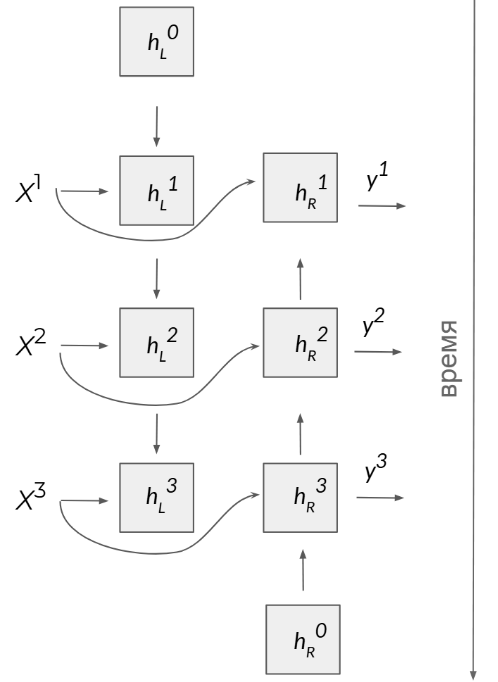

In [14]:
Image("images/bidirectional_rnn.png", width="50%")

До этого момента `RNN` работала так: сначала для одного токена проходила до конца вдоль оси слоев, а только потом переходила к следующему токену в последовательности. Что если поменять этот порядок и сначала двигаться вдоль оси токенов (времени), а только потом переходить к следующему слою, но при этом у нас будет не только прямой путь, но и обратный, который будет читать последовательность токенов в обратном направлении. 

Можно рассматривать `Bidirectional RNN` слой как 2 подслоя, которые читают последовательность в разных направлениях. 

---

Прямое направление (**Forward RNN** читает $t = 1 \rightarrow T$):

- Это стандартная формула, которая уже использовалась раньше. $\newline$

- $\overrightarrow{h_t^{(l)}} = \tanh \left( W^{(l)}_{\overrightarrow{xh}} \cdot x_t^{(l)} + W^{(l)}_{\overrightarrow{hh}} \cdot \overrightarrow{h^{(l)}_{t-1}} + b_{\vec{x}}^{(l)} + b_{\vec{h}}^{(l)} \right)$

Обратное направление (**Backward RNN** читает $t = T \rightarrow 1$):

- Формула та же, но $h_t$ зависит от $h_{t+1}$ (следующего шага, который для нее является "предыдущим" во времени). $\newline$

- $\overleftarrow{h_t^{(l)}} = \tanh \left( W^{(l)}_{\overleftarrow{xh}} \cdot x_t^{(l)} + W^{(l)}_{\overleftarrow{hh}} \cdot \overleftarrow{h^{(l)}_{t+1}} + b_{\overleftarrow{x}}^{(l)} + b^{(l)}_{\overleftarrow{h}} \right)$

Финальный выход $y_t$ (который пойдет на следующий слой) — это конкатенация двух векторов.

- $y^{(l)}_t = [\overrightarrow{h_t^{(l)}}; \overleftarrow{h_t^{(l)}}]$ $\newline$

В начальный момент времени:

- Для прямого направления создается пустой вектор $\overrightarrow{h_0}$ (заполнен нулями). $\newline$

- Для обратного направления тоже создается пустой вектор $\overleftarrow{h_{T+1}}$ (заполнен нулями).

---

**Зачем вообще это нужно?**

В момент времени $t$:

- $\overrightarrow{h_t}$ (Forward) знает только прошлое: $x_1, x_2, ..., x_t$. Он понятия не имеет, что будет в $x_{t+1}$. $\newline$

- $\overleftarrow{h_t}$ (Backward) знает только будущее: $x_t, x_{t+1}, ..., x_T$. Он понятия не имеет, что было в $x_{t-1}$.

Смысл в том, что конкатенация двух этих векторов позволяет собрать информацию и о прошлом, и о будущем.

---

**Когда применимо:**

- Когда у нас доступна полная последовательность входных данных, так как `Backward RNN` должна точно знать, где заканчивается входная последовательность, чтобы начать её обрабатывать с конца. $\newline$

- Когда на каждом временном шаге решение зависит не только от предшествующих шагов, но и от последующих шагов. 

**Когда не применимо:**

- Когда данные поступают по одному шагу в процессе, и мы не можем заранее увидеть "будущее". $\newline$

- Когда задача — предсказать следующий элемент на основе предыдущих, и будущего ещё нет.

## Пример реализации `Bidirectional RNN`

In [15]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size    # Размерность входного вектора x_t
        self.hidden_size = hidden_size  # Размер скрытого состояния h_t
        self.num_layers = num_layers    # Количество рекуррентных слоёв
        
        # Список линейных слоёв для входов (W_xh)
        # Первый слой: input_size → hidden_size
        # Остальные слои: 2*hidden_size → hidden_size
        self.input_layers_forward = nn.ModuleList([
            nn.Linear(input_size, hidden_size) if i == 0 else nn.Linear(2*hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.input_layers_backward = nn.ModuleList([
            nn.Linear(input_size, hidden_size) if i == 0 else nn.Linear(2*hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        # Список линейных слоёв для скрытых состояний (W_hh)
        self.hidden_layers_forward = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.hidden_layers_backward = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        """
        x: [batch, seq_len, input_size]
        """
        device = x.device
        x = x.transpose(0, 1)              # [seq_len, batch, input_size]
        seq_len, batch_size, _ = x.size()
        
        h = []                             # хранит конечные скрытые состояния (h_T)
        h_next = None                      # хранит выходы текущего слоя, которые станут входами для следующего
        # Итерация по каждому слою
        for layer in range(self.num_layers):
            # Инициализация начального состояния нулями для прямого и обратного направления
            h_forward = [torch.zeros(batch_size, self.hidden_size, device=device)]
            h_backward = [torch.zeros(batch_size, self.hidden_size, device=device)]
            # Итерация по времени (t) в пределах последовательности.
            for t in range(seq_len):
                # --- ПРЯМОЕ НАПРАВЛЕНИЕ (FORWARD) ---
                x_t = x[t] if layer == 0 else h_next[t]
                h_forward.append(
                    torch.tanh(
                        self.input_layers_forward[layer](x_t)
                        + self.hidden_layers_forward[layer](h_forward[t])
                    )
                )
                # --- ОБРАТНОЕ НАПРАВЛЕНИЕ (BACKWARD) ---
                # Вход x_t: берем элементы в обратном порядке (seq_len - t - 1).
                x_t = x[seq_len-t-1] if layer == 0 else h_next[seq_len-t-1]
                h_backward.append(
                    torch.tanh(
                        self.input_layers_backward[layer](x_t)
                        + self.hidden_layers_backward[layer](h_backward[t])
                    )
                )
                
            h_f = torch.stack(h_forward[1:])          # Собираем состояния прямого направления
            h_b = torch.stack(h_backward[1:][::-1])   # Собираем состояния обратного направления
            h_next = torch.cat([h_f, h_b], dim=2)     # Формирование выходов текущего слоя
            h.append(h_f[-1].clone())                 # Сохранение конечных скрытых состояний
            h.append(h_b[0].clone())
        
        h = torch.stack(h)                            # [num_layers * 2, batch, hidden_size]
        out = h_next.transpose(0, 1)                  # [batch, seq_len, 2 * hidden_size]
        
        return out, h

In [16]:
model = BiRNN(input_size=5, hidden_size=10, num_layers=3)

In [17]:
x = torch.rand(6, 10, 5)  # [batch, seq_len, input_size]
out, h = model(x)  

In [18]:
out.shape  # [batch, seq_len, 2*hidden_size]

torch.Size([6, 10, 20])

In [19]:
h.shape  # [2*num_layers, batch, hidden_size]

torch.Size([6, 6, 10])

# LSTM

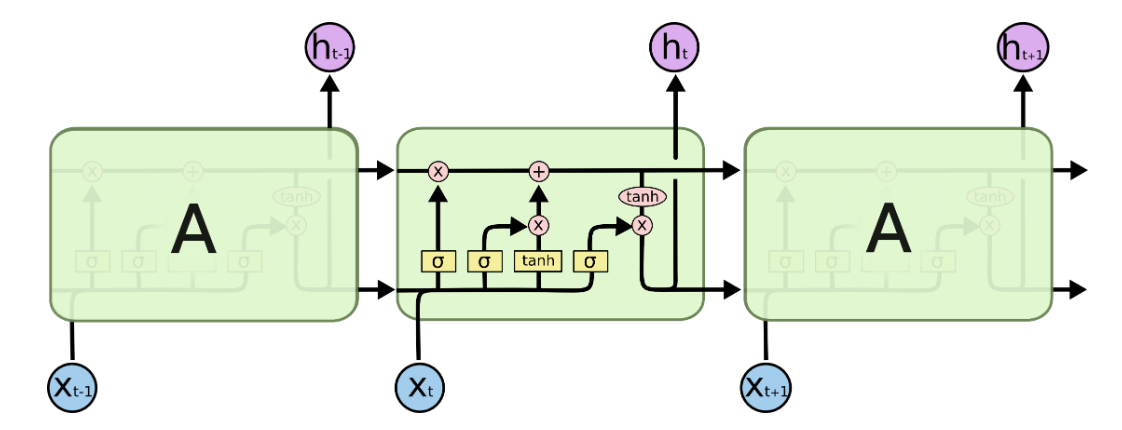

In [20]:
Image("images/LSTM.png", width="80%")

Одним из способов борьбы с затуханием градиентов в рекуррентных нейросетях является применение `LSTM` (Long Short-Term Memory) слоев.

В `RNN` при обратном распространении ошибки градиенты, проходя через множество шагов во времени, затухают (становятся почти нулевыми) или взрываются (становятся огромными). В результате сеть либо не может обучиться на "далеком" прошлом, либо обучение становится нестабильным.

`LSTM` (Long Short-Term Memory) — это особый тип RNN, специально разработанный для решения этой проблемы. Он способен запоминать информацию на очень длительные периоды.

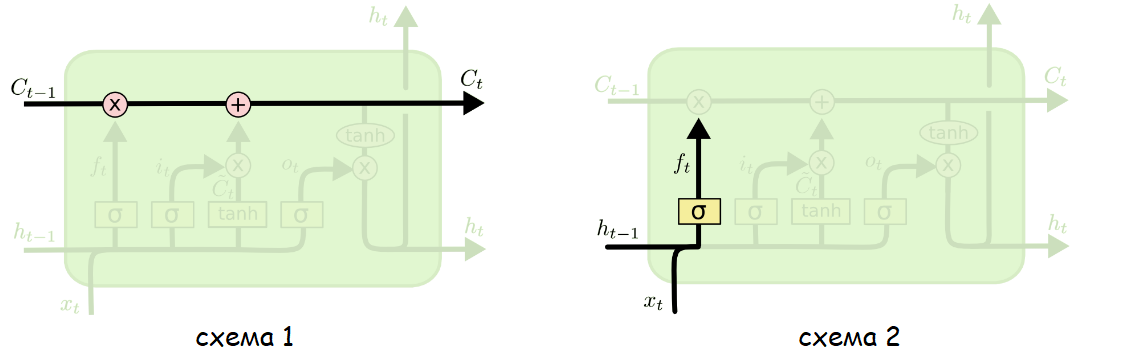

In [21]:
Image("images/LSTM_scheme1.png", width="85%")

Ключевая идея `LSTM` – это состояние ячейки (Cell State), которое выделено на **схеме 1**. 

Используя состояние ячейки (Cell State), `LSTM` может добавлять или удалять информацию. Этими добавлениями и удалениями управляют специальные структуры – вентили (gates).

Вентиль — это просто способ "по желанию" пропускать информацию. Он состоит из сигмоидной функции $\sigma$ и операции поэлементного умножения. Сигмоида выдает число от 0 до 1, где 0 означает "ничего не пропускать", а 1 – "пропустить всё".

В `LSTM` блоке таких вентилей три, и они контролируют состояние ячейки $C_t$.

---

### Принцип работы `LSTM` блока:

`LSTM` отслеживает два состояния:

- $C_t$ — состояние ячейки (долгосрочная память). $\newline$

- $h_t$ — скрытое состояние (краткосрочная память).

На вход ячейка получает:

- $x_t$ — текущий вход (эмбеддинг слова или вектор скрытого состояния с предыдущего слоя). $\newline$

- $h_{t-1}$ — предыдущее скрытое состояние. $\newline$

- $C_{t-1}$ — предыдущее состояние ячейки.

**Шаг 1. Вентиль Забывания (Forget Gate).**

$$f_t = \sigma\bigl(W_f\cdot [\,h_{t-1}, x_t\,] + b_f\bigr)$$

Решает, какую информацию нужно выбросить из старого состояния ячейки $C_{t-1}$ (выделен на **схеме 2**).

1. Берем $h_{t-1}$ (что мы знали на прошлом шаге) и $x_t$ (что мы видим сейчас), производим их конкатенацию. Пропускаем полученный вектор через сигмоиду $\sigma$. $\newline$

2. На выходе получаем вектор $f_t$ (forget), состоящий из 0 и 1. $\newline$

3. $1$ означает "сохранить" эту часть $C_{t-1}$, а $0$ — "забыть".

Пример: Если $C_{t-1}$ хранит род существительного "он", а $x_t$ — это новое существительное "она", вентиль забывания научится выдавать $0$ для старого рода.

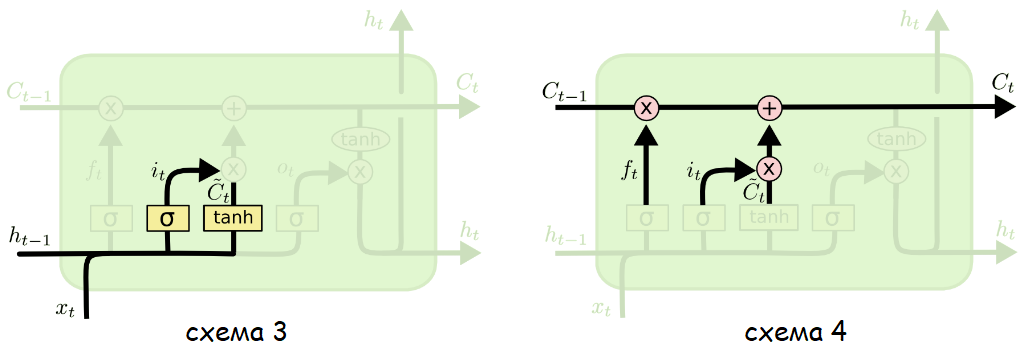

In [22]:
Image("images/LSTM_scheme2.png", width="80%")

**Шаг 2. Вентиль Входа (Input Gate).**

Решает, какую новую информацию добавить в состояние ячейки $C_{t-1}$ (выделен на **схеме 3**).

Этот шаг состоит из двух частей:

**Какие значения обновлять?**

$$i_t = \sigma\bigl(W_i \cdot [\,h_{t-1}, x_t\,] + b_i\bigr)$$

- Вентиль входа $i_t$ решает, какие части $C_{t-1}$ будут обновляться. Он так же, как и $f_t$, смотрит на $h_{t-1}$ и $x_t$ и выдает вектор из 0 и 1.

**Какую информацию добавлять?**

$$\tilde{C}_t = \tanh\bigl(W_C \cdot [\,h_{t-1}, x_t\,] + b_C\bigr)$$

- С учетом $h_{t-1}$ и $x_t$ формируется информация (вектор), которую можно добавить в текущее состояние ячейки (Cell State).

Пример: В примере с родом $i_t$ решит, что информацию о роде нужно обновить, а $\tilde{C}_t$ сгенерирует сам новый род ("она").

**Шаг 3. Обновление Состояния Ячейки (Cell State).**

Создает новое состояние ячейки $C_t$ (выделен на **схеме 4**).

Теперь у нас есть все необходимое:

- $f_t$ (что забыть) $\newline$

- $C_{t-1}$ (старая память) $\newline$

- $i_t$ (что добавить) $\newline$

- $\tilde{C}_t$ (новая информация)

Мы делаем два действия:

- Забываем старое: $f_t \odot C_{t-1}$ (Поэлементное умножение. Если $f_t=0$, старая память стирается). $\newline$

- Добавляем новое: $i_t \odot \tilde{C}_t$ (Поэлементное умножение. Если $i_t=0$, новая информация игнорируется).

И складываем их:

$$C_t = (f_t \odot C_{t-1}) + (i_t \odot \tilde{C}_t)$$

Мы взяли старое состояние ячейки $C_{t-1}$, стерли с него то, что велел $f_t$, и добавили новую информацию $\tilde{C}_t$ в те места, куда разрешил $i_t$.

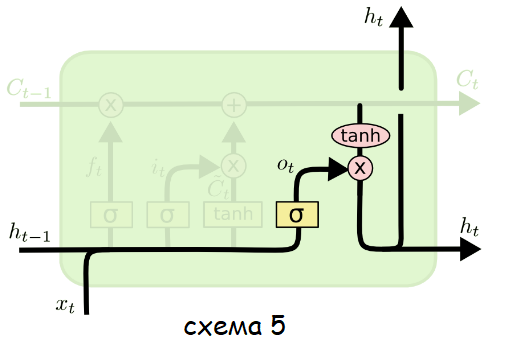

In [23]:
Image("images/LSTM_scheme3.png", width="40%")

**Шаг 4. Вентиль Выхода (Output Gate).**

$$o_t = \sigma\bigl(W_o \cdot [\,h_{t-1}, x_t\,] + b_o\bigr)$$

$$h_t = o_t \odot \tanh(C_t)$$

Решает, что выдать на выходе (скрытое состояние $h_t$, выделен на **схеме 5**).

Выход $h_t$ — это "отфильтрованная" версия нашей долгосрочной памяти $C_t$.

- Вентиль выхода (Output Gate) $o_t$ решает, какую часть нашей памяти $C_t$ мы хотим выдать наружу. Он снова смотрит на $h_{t-1}$ и $x_t$. $\newline$

- Новая память $C_t$ пропускается через tanh (чтобы "сжать" значения). $\newline$

- Затем полученный вектор умножается на фильтр $o_t$. Получается новый вектор скрытого состояния, куда попала лишь часть нужной в данный момент информации.

Пример: Память $C_t$ может хранить род ("она") и то, что это существительное. Если следующая задача — предсказать глагол, $o_t$ может решить "показать" (выдать 1) только информацию о роде (чтобы согласовать окончание глагола), но "скрыть" (выдать 0) информацию о том, что это существительное.

---

Формулы для LSTM:

<font size="3">
$$
\begin{aligned}
i_t^{(l)} &= \sigma\bigl(W_{ii}^{(l)}\,x_t^{(l)} + W_{hi}^{(l)}\,h_{t-1}^{(l)} + b_{ii}^{(l)} + b_{hi}^{(l)}\bigr) \\
f_t^{(l)} &= \sigma\bigl(W_{if}^{(l)}\,x_t^{(l)} + W_{hf}^{(l)}\,h_{t-1}^{(l)} + b_{if}^{(l)} + b_{hf}^{(l)}\bigr) \\
g_t^{(l)} &= \tanh\bigl(W_{ig}^{(l)}\,x_t^{(l)} + W_{hg}^{(l)}\,h_{t-1}^{(l)} + b_{ig}^{(l)} + b_{hg}^{(l)}\bigr) \\
o_t^{(l)} &= \sigma\bigl(W_{io}^{(l)}\,x_t^{(l)} + W_{ho}^{(l)}\,h_{t-1}^{(l)} + b_{io}^{(l)} + b_{ho}^{(l)}\bigr) \\
c_t^{(l)} &= f_t^{(l)} \odot c_{t-1}^{(l)} + i_t^{(l)} \odot g_t^{(l)} \\
h_t^{(l)} &= o_t^{(l)} \odot \tanh\bigl(c_t^{(l)}\bigr)
\end{aligned}
$$
</font>

Формулы для LSTM в более компактном виде через конкатенацию векторов: $\newline$

<font size="3">
$$
\begin{aligned}
z_t^{(l)} &= [\,x_t^{(l)},\,h_{t-1}^{(l)}] \\
i_t^{(l)} &= \sigma\bigl(W_i^{(l)}\,z_t^{(l)} + b_i^{(l)}\bigr) \\
f_t^{(l)} &= \sigma\bigl(W_f^{(l)}\,z_t^{(l)} + b_f^{(l)}\bigr) \\
g_t^{(l)} &= \tanh\bigl(W_g^{(l)}\,z_t^{(l)} + b_g^{(l)}\bigr) \\
o_t^{(l)} &= \sigma\bigl(W_o^{(l)}\,z_t^{(l)} + b_o^{(l)}\bigr) \\
c_t^{(l)} &= f_t^{(l)} \odot c_{t-1}^{(l)} + i_t^{(l)} \odot g_t^{(l)} \\
h_t^{(l)} &= o_t^{(l)} \odot \tanh\bigl(c_t^{(l)}\bigr)
\end{aligned}
$$
</font>

$g_t^{(l)}$ − то же самое, что и $\tilde{C}_t$.

где:


$\sigma(x)=\frac1{1+e^{-x}} − \text{сигмоида}; $

$\tanh(x)=\frac{e^{x}-e^{-x}}{e^{x}+e^{-x}} − \text{гиперболический тангенс}; $

$\odot − \text{поэлементное умножение}; $

$x_t^{(l)} − \text{входной вектор слоя }l\text{ на шаге }t; $

$h_{t-1}^{(l)} − \text{скрытое состояние слоя }l\text{ на шаге }t-1; $

$c_{t}^{(l)} − \text{состояние ячейки (cell state) слоя }l\text{ на шаге }t; $

$z_t^{(l)} = [\,x_t^{(l)},\,h_{t-1}^{(l)}] − \text{конкатенация векторов } x_t^{(l)}  \text{ и }h_{t-1}^{(l)}.$


## Пример реализации `LSTM`

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.i_weights = nn.ModuleList([
            nn.Linear(input_size + hidden_size, hidden_size) if i == 0 
            else nn.Linear(hidden_size * 2, hidden_size)
            for i in range(num_layers)
        ])
        self.f_weights = nn.ModuleList([
            nn.Linear(input_size + hidden_size, hidden_size) if i == 0 
            else nn.Linear(hidden_size * 2, hidden_size)
            for i in range(num_layers)
        ])
        self.g_weights = nn.ModuleList([
            nn.Linear(input_size + hidden_size, hidden_size) if i == 0 
            else nn.Linear(hidden_size * 2, hidden_size)
            for i in range(num_layers)
        ])
        self.o_weights = nn.ModuleList([
            nn.Linear(input_size + hidden_size, hidden_size) if i == 0 
            else nn.Linear(hidden_size * 2, hidden_size)
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        """
        x: [batch, seq_length, input_size]
        """
        device = x.device
        x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        
        out = []
        for t in range(seq_len):
            h_next = []
            c_next = []
            for layer in range(self.num_layers):
                x_t = x[t] if layer == 0 else h_next[layer-1]
                
                xh_t = torch.cat([x_t, h[layer]], dim=1)
                f_t = torch.sigmoid(self.f_weights[layer](xh_t))
                i_t = torch.sigmoid(self.i_weights[layer](xh_t))
                o_t = torch.sigmoid(self.o_weights[layer](xh_t))
                c_add = torch.tanh(self.g_weights[layer](xh_t)) 
                
                c_t = f_t * c[layer] + i_t * c_add
                c_next.append(c_t)
                h_next.append(
                    o_t * torch.tanh(c_t)
                )
            h = torch.stack(h_next)
            c = torch.stack(c_next)
            out.append(h[-1].clone())
            
        out = torch.stack(out)
        out = out.transpose(0, 1)
        
        return out, (h, c)

## [nn.LSTM](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

**`class torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)`**

- **`input_size`** — размерность вектора признаков. Например, если в тексте каждое слово представлено вектором (word embedding) размерности 300, то `input_size=300`. $\newline$

- **`hidden_size`** — размерность вектора скрытого состояния. $\newline$

- **`num_layers`** — количество слоев. $\newline$

- **`bias`** — флаг, который определяет, добавлять ли обучаемые смещения (bias) ко всем весам внутри LSTM. $\newline$

- **`batch_first`** — флаг, который определяет порядок измерений входных и выходных тензоров. $\newline$

    - Значение `False`: Вход/выход ожидается в формате `(sequence_length, batch_size, feature)`. $\newline$

    - Значение `True`: Вход/выход ожидается в формате `(batch_size, sequence_length, feature)`. $\newline$

    - `feature` — это, например, размер входного эмбеддинга (`input_size`). $\newline$

- **`dropout`** — если не равно нулю, добавляет слой `Dropout` (с вероятностью равной **`dropout`**) на выходах каждого слоя LSTM кроме последнего. $\newline$

- **`bidirectional`** — если `True`, то LSTM становится двунаправленным. Если `bidirectional=True`, то последняя размерность выходных тензоров (`output` и `h_n`) будет равна `D * H_out`, где `D=2`. $\newline$

- **`proj_size`** — позволяет разделить размер внутренней памяти $H_{cell}$ и размер выходной $H_{out}$. $\newline$

    - `LSTM` внутри по-прежнему использует `hidden_size` для состояния ячейки $C_t$ (долгосрочной памяти). Но на выходе он добавляет линейный слой, который "сжимает" скрытое состояние $h_t$ до размера **`proj_size`**. $\newline$
    
    - Влияние на размерности: $H_{cell}$ (размер `c_n`) = `hidden_size`. $\newline$
    
    - Влияние на размерности: $H_{out}$ (размер `h_n` и `output`) = **`proj_size`** (если `proj_size > 0`) или `hidden_size` (если `proj_size = 0`).

---

$N$ $-$ batch size;

$L$ $-$ длина последовательности;

$D$ $=$ `2` если `bidirectional=True`, иначе `1`;

$H_{in}$ $=$ `input_size`;

$H_{cell}$ $=$ `hidden_size`;

$H_{out}$ $=$ `proj_size` если `proj_size > 0`, иначе `hidden_size`;

**Входы** `input, (h_0, c_0)`:

**`input`**:

- при `batch_first=False` форма входного тензора: $(L, N, H_{in})$ $\newline$

- при `batch_first=True` форма входного тензора: $(N, L, H_{in})$

**`(h_0, c_0)`**: 

Это необязательный вход. Если их не подать, PyTorch автоматически создаст их в виде тензоров из нулей. Они нужны, если необходимо продолжить работу, используя полученные `(h_0, c_0)` с предыдущей сети `LSTM`.

**Выходы** `output, (h_n, c_n)`:

**`output`**:

Cодержит скрытые состояния (hidden_state) самого последнего слоя `LSTM` для каждого временного шага.

- при `batch_first=False` форма выходного тензора: $(L, N, D * H_{out})$. Например, если `bidirectional=True` и $H_{out}=64$, то $D * H_{out} = 2 * 64 = 128$. $\newline$

- при `batch_first=True` форма выходного тензора: $(N, L, D * H_{out})$.

**`(h_n, c_n)`**:

`h_n` и `c_n` — это скрытые состояния и состояния ячейки после обработки самого последнего элемента последовательности, которые делаются для каждого слоя (`num_layers`) и каждого направления (`bidirectional`).

Форма тензора для `h_n` — $(D * num\_layers, N, H_{out})$

Форма тензора для `c_n` — $(D * num\_layers, N, H_{cell})$.

Например, если `num_layers=2` и `bidirectional=True` (`D=2`), то `D * num_layers = 4`. Первое измерение для `h_n` и `c_n` будет иметь размер 4, и оно будет организовано так:

- `h_n[0]` = Финальное состояние Forward, Слой 0 $\newline$

- `h_n[1]` = Финальное состояние Backward, Слой 0 $\newline$

- `h_n[2]` = Финальное состояние Forward, Слой 1 $\newline$

- `h_n[3]` = Финальное состояние Backward, Слой 1

## Работа с последовательностями переменной длины

**Пример**: Есть батч данных, например, 3 предложения:

- `"Я люблю PyTorch"` (3 слова) $\newline$

- `"Я очень люблю PyTorch"` (4 слова) $\newline$

- `"Я"` (3 слова)

Они превращаются в тензоры:

- `seq1` (shape `[3, 300]`) $\newline$

- `seq2` (shape `[4, 300]`) $\newline$

- `seq3` (shape `[1, 300]`)

`nn.LSTM` (как и любая нейросеть) ожидает на вход один "прямоугольный" тензор. Нельзя просто "склеить" эти тензоры — у них разная длина.

Решение:

- Нужно дополнить короткие последовательности специальным токеном (например, нулями) до длины самой длинной. $\newline$

- Но просто дополнить нулями неэффективно, LSTM будет впустую тратить время, обрабатывая эти нули. Решение в PyTorch — упаковка в специальный класс `PackedSequence`, который говорит LSTM: "Вот данные, но реальная длина первой последовательности — 3, а второй — 4, третьей — 1". LSTM использует эту информацию, чтобы не делать вычисления для паддинг-элементов.

### [nn.utils.rnn.pad_sequence](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html)

Эта функция находит $L_{max}$ (максимальную длину) в списке и "склеивает" список тензоров разной длины в один большой "прямоугольный" тензор, дополняя значениями `padding_value` короткие последовательности до длины $L_{max}$.

`torch.nn.utils.rnn.pad_sequence(sequences, batch_first=False, padding_value=0.0, padding_side='right')`

- `sequences` — список тензоров последовательностей переменной длины. Каждый тензор имеет форму $[L_i, *]$, где $L_i$ $-$ длина последовательности, $*$ $-$ другие размерности. $\newline$

- `batch_first` — если `True`, то итоговый тензор будет иметь форму $[B, T, *]$, иначе $[T, B, *]$, где $B$ $-$ число последовательностей (`batch size`), $T$ $-$ максимальная длина среди всех $L_i$. $\newline$

- `padding_value` — значение, которым заполняются недостающие элементы (по умолчанию 0). $\newline$

- `padding_side` — сторона, с которой добавляется паддинг (по умолчанию "right").

In [25]:
from torch.nn.utils.rnn import pad_sequence

In [26]:
a = torch.ones(25, 300)
b = torch.ones(22, 300)
c = torch.ones(15, 300)

In [27]:
pad_sequence([a, b, c], batch_first=True).shape

torch.Size([3, 25, 300])

### [nn.utils.rnn.pack_padded_sequence](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html#torch.nn.utils.rnn.pack_padded_sequence)

Принимает тензор, где все последовательности уже приведены к одной длине (например, получен после применения `pad_sequence`) и список настоящих длин каждой последовательности, упаковывает этот тензор в объект `PackedSequence`, благодаря которому `RNN/LSTM` игнорирует паддинг, экономя вычисления.

`torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)`

- `input` — это батч с выровненными последовательностями. $\newline$

- `lengths` — список или тензор (на **CPU**) с длинами каждой последовательности (до паддинга). $\newline$

- `batch_first` — если `True`, то `input` $-$ тензор формы $[B, T, *]$, если `False` $-$ тензор формы $[T, B, *]$. $\newline$

- `enforce_sorted` — если `True`, требует, чтобы длины последовательностей уже были отсортированы по убыванию (т.е. самый длинный первый). Если они не отсортированы, можно поставить `False`, и функция сама отсортирует. Если `enforce_sorted=True`, а в `lengths` длины не отсортированы, выдаст ошибку.


In [28]:
from torch.nn.utils.rnn import pack_padded_sequence

In [29]:
inp = pad_sequence([b, a, c], batch_first=True)

In [30]:
lengths = [22, 25, 15]

In [31]:
packed_tensor = pack_padded_sequence(inp, lengths, batch_first=True, enforce_sorted=False)

In [32]:
packed_tensor

PackedSequence(data=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), batch_sizes=tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        1]), sorted_indices=tensor([1, 0, 2]), unsorted_indices=tensor([1, 0, 2]))

**Почему требуются именно отсортированные последовательности?**

- Чтобы GPU мог выполнять одну большую операцию вместо тысячи маленьких. GPU хорошо работает с непрерывными блоками данных. 

Если представить батч с длинами [5, 3, 2]:

- `t=0`: Активны 3 последовательности. $\newline$

- `t=1`: Активны 3 последовательности. $\newline$

- `t=2`: Активны 2 последовательности (первая и вторая). **Третья закончилась**. $\newline$

- `t=3`: Активна 1 последовательность (первая). **Вторая закончилась**. $\newline$

- `t=4`: Активна 1 последовательность (первая).

Видно что последовательности "заканчиваются" только с конца. Для GPU это выглядит так:

- `t=0, t=1`: "Обработай непрерывный блок из 3 элементов". $\newline$

- `t=2`: "Обработай непрерывный блок из 2 элементов". $\newline$

- `t=3, t=4`: "Обработай непрерывный блок из 1 элемента".

Если бы последовательности были не отсортированы по длине, то в процессе могли появиться "дырявые" батчи, что неэффективно. Таким образом GPU просто сдвигает указатель на сколько данных ему читать, вместо того, чтобы прыгать по памяти. Сортировка нужна, чтобы получить непрерывные блоки для эффективной обработки.

---

**Как формируются параметры `data` и `batch_sizes` в объекте `PackedSequence`?**

Есть отсортированный батч [5, 3, 2]:

- `Seq_A = [A1, A2, A3, A4, A5]` $\newline$

- `Seq_B = [B1, B2, B3]` $\newline$

- `Seq_C = [C1, C2]`

Прямоугольный (padded) тензор `[T, B, H] = [5, 3, H]` выглядит так:

```python
[ [A1, B1, C1],  # t=0
  [A2, B2, C2],  # t=1
  [A3, B3,  0],  # t=2
  [A4,  0,  0],  # t=3
  [A5,  0,  0] ] # t=4
```

`pack_padded_sequence` "нарезает" его по `batch_sizes = [3, 3, 2, 1, 1]`:

- Шаг `t=0` (берем 3 элемента): `[A1, B1, C1]` $\newline$

- Шаг `t=1` (берем 3 элемента): `[A2, B2, C2]` $\newline$

- Шаг `t=2` (берем 2 элемента): `[A3, B3]` $\newline$

- Шаг `t=3` (берем 1 элемент): `[A4]` $\newline$

- Шаг `t=4` (берем 1 элемент): `[A5]`

Тензор `data` — это просто все эти срезы, склеенные в один длинный вектор: 

- `data = [A1, B1, C1, A2, B2, C2, A3, B3, A4, A5]`

`nn.LSTM` читает `batch_sizes[0]=3`, берет первые 3 элемента из `data`. Затем читает `batch_sizes[1]=3`, берет следующие 3. Затем `batch_sizes[2]=2`, берет следующие 2... Это предсказуемый и быстрый доступ к памяти.

---

**Зачем нужны `sorted_indices` и `unsorted_indices`?**

В процессе работы батч был отсортирован, но ответы (labels) к батчу остались в исходном порядке. PackedSequence хранит эти индексы, чтобы автоматически восстановить исходный порядок после обработки.

Например, DataLoader выдал батч и его метки:

- `batch_X = [seq_A (len 3), seq_B (len 5), seq_C (len 2)]` $\newline$

- `batch_Y = [label_A, label_B, label_C]`

`pack_padded_sequence` видит, что батч не отсортирован. Он сортирует его:

- `sorted_batch_X = [seq_B (len 5), seq_A (len 3), seq_C (len 2)]` $\newline$

- Он запоминает, как он это сделал: `sorted_indices = [1, 0, 2]` $\newline$

- Он запоминает, как вернуть все обратно: `unsorted_indices = [1, 0, 2]` (в данном случае они совпали, но `unsorted_indices` — это обратная перестановка). 

LSTM обрабатывает `sorted_batch_X` и выдает отсортированный выход:

- `sorted_output = [out_B, out_A, out_C]`

Если теперь сравнить `sorted_output` с `batch_Y`, все перепутается:

- `out_B` будет сравниваться с `label_A` $\newline$

- `out_A` будет сравниваться с `label_B`

Вот здесь и нужен `pad_packed_sequence`. Он не только "разупаковывает" `sorted_output`, но и смотрит на `unsorted_indices` и восстанавливает исходный порядок:

- `final_output = [out_A, out_B, out_C]`

### [nn.utils.rnn.pack_sequence](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_sequence.html#torch.nn.utils.rnn.pack_sequence)

Удобная обертка, которая объединяет `pad_sequence` и `pack_padded_sequence`. Она принимает список тензоров (как `pad_sequence`), сама применяет паддинг и сразу пакует.

`torch.nn.utils.rnn.pack_sequence(sequences, enforce_sorted=True)`

- `sequences` — список тензоров формы $[L_i, *]$, где $L_i$ $-$ длина последовательности, $*$ $-$ другие размерности. $\newline$

- `enforce_sorted` — если `True`, требует, чтобы длины последовательностей уже были отсортированы по убыванию (т.е. самый длинный первый). Если они не отсортированы, можно поставить `False`, и функция сама отсортирует. Если `enforce_sorted=True`, а в `lengths` длины не отсортированы, выдаст ошибку.

In [33]:
from torch.nn.utils.rnn import pack_sequence

In [34]:
a = torch.ones(22, 300)
b = torch.ones(25, 300)
c = torch.ones(15, 300)

In [35]:
output = pack_sequence([a, b, c], enforce_sorted=False)

In [36]:
output

PackedSequence(data=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), batch_sizes=tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        1]), sorted_indices=tensor([1, 0, 2]), unsorted_indices=tensor([1, 0, 2]))

### [nn.utils.rnn.pad_packed_sequence](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html)

Обратная `pack_padded_sequence` операция. Превращает `PackedSequence` (который обычно возвращает `RNN/LSTM`) обратно в обычный "прямоугольный" тензор (с нулями). Эта операция нужна, так как следующие слои (например, Linear слой для классификации) не умеют работать с `PackedSequence`. Им нужен "прямоугольный" тензор формы `[Batch, Time, Feature]`.

`torch.nn.utils.rnn.pad_packed_sequence(sequence, batch_first=False, padding_value=0.0, total_length=None)`

- `sequence` — объект `PackedSequence`. $\newline$

- `batch_first` — если `True`, то полученный тензор будет иметь форму $[B, T, *]$, иначе $[T, B, *]$, где $B$ $-$ число последовательностей (`batch size`), $T$ $-$ длина самой длинной последовательности. $\newline$

- `padding_value` — значение, которым заполняются недостающие элементы (по умолчанию 0). 

Возвращает дополненный нулями тензор и тензор длин последовательностей в батче, причем элементы батча будут переупорядочены в том порядке, в котором они подавались изначально. 

In [37]:
from torch.nn.utils.rnn import pad_packed_sequence

In [38]:
output, output_lengths = pad_packed_sequence(output, batch_first=True)

In [39]:
output.shape

torch.Size([3, 25, 300])

In [40]:
output_lengths

tensor([22, 25, 15])

# [Seq2Seq](https://education.yandex.ru/handbook/ml/article/nejroseti-dlya-raboty-s-posledovatelnostyami) на основе LSTM и Attention

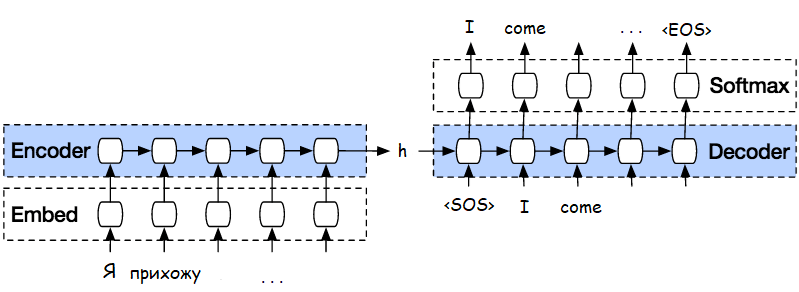

In [54]:
Image("images/seq2seq.png")

In [45]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, enc_outputs, enc_projection, hidden, mask):
        """
        enc_outputs: [batch, seq_len1, 2 * hidden_size] 
        hidden: [batch, hidden_size]
        mask: [batch, seq_len1]
        """
        hidden = hidden.unsqueeze(1).expand(hidden.shape[0],       # [batch, seq_len1, hidden_size]
                                            enc_outputs.shape[1], 
                                            hidden.shape[1])  
        score = torch.tanh(self.W(hidden) + enc_projection)        # [batch, seq_len1, hidden_size]
        score = self.v(score).squeeze(2)                           # [batch, seq_len1]
        score = score.masked_fill(mask == False, -1e9)             # [batch, seq_len1]
        attention = self.softmax(score)                            # [batch, seq_len1]
        context = torch.bmm(attention.unsqueeze(1), enc_outputs)   # [batch, 1, 2 * hidden_size]
        return context


class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, embedding=None, vocab_size=None, dropout=0.5):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        if embedding:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(vocab_size, input_size)
        
        self.encoder = nn.LSTM(input_size, hidden_size, 
                               num_layers=num_layers, 
                               batch_first=True, 
                               bidirectional=True,
                               dropout=dropout)
        self.decoder = nn.LSTM(input_size + (2 * hidden_size), hidden_size, 
                               num_layers=num_layers, 
                               batch_first=True, 
                               dropout=dropout)
        self.adapter_h = nn.Linear(2 * hidden_size, hidden_size)
        self.adapter_c = nn.Linear(2 * hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size * 3, vocab_size)
        self.attention = Attention(hidden_size)
        
    def encode(self, enc_x, enc_len):
        """
        enc_x: Long - [batch, seq_len1] 
        enc_len: Long - [batch]
        """
        enc_x = self.embedding(enc_x)  # [batch, seq_len1, input_size] 

        packed_enc_x = nn.utils.rnn.pack_padded_sequence(            
            enc_x, enc_len, batch_first=True, enforce_sorted=False
        )
        # outputs: PackedSequence (в распакованном виде было бы [batch, seq_len1, 2 * hidden_size])
        # h: [2 * num_layers, batch, hidden_size] (2 т.к. bidirectional: слои forward и backward)
        # c: [2 * num_layers, batch, hidden_size]
        outputs, (h, c) = self.encoder(packed_enc_x)                      
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs,            # [batch, seq_len1, 2 * hidden_size]
                                                      batch_first=True)
        
        decoder_init_h = torch.cat([h[::2, :, :], h[1::2, :, :]], dim=2)  # [num_layers, batch, 2 * hidden_size]
        decoder_init_c = torch.cat([c[::2, :, :], c[1::2, :, :]], dim=2)  # [num_layers, batch, 2 * hidden_size]
        decoder_init_h = torch.tanh(self.adapter_h(decoder_init_h))       # [num_layers, batch, hidden_size]
        decoder_init_c = torch.tanh(self.adapter_c(decoder_init_c))       # [num_layers, batch, hidden_size]
        
        return outputs, decoder_init_h, decoder_init_c

    def create_mask(self, enc_len, max_len, device):
        batch_size = enc_len.shape[0]
        mask = torch.arange(max_len).expand(batch_size, max_len) < enc_len.unsqueeze(1)
        
        return mask.to(device)
    
    def forward(self, enc_x, dec_x, enc_len, teacher_forcing_ratio=0.5): 
        """ 
        enc_x: Long - [batch, seq_len1] 
        dec_x: Long - [batch, seq_len2] 
        enc_len: Long - [batch] 
        """
        # enc_outputs: [batch, seq_len1, 2 * hidden_size] 
        # decoder_init_h: [num_layers, batch, hidden_size] 
        # decoder_init_c: [num_layers, batch, hidden_size] 
        enc_outputs, decoder_init_h, decoder_init_c = self.encode(enc_x, enc_len) 
        enc_projection = self.attention.U(enc_outputs) 
        
        decoder_input = self.embedding(dec_x)                        # [batch, seq_len2, input_size] 
        mask = self.create_mask(enc_len, enc_outputs.shape[1],       # [batch, seq_len1]
                                device=enc_x.device)     

        batch_size = dec_x.shape[0]
        trg_len = dec_x.shape[1]

        outputs = torch.zeros(batch_size, trg_len, self.vocab_size, device=enc_x.device)
        hidden, cell = decoder_init_h, decoder_init_c   
        dec_input = decoder_input[:, :1]                             # [batch, 1, input_size] 
        
        for t in range(trg_len):
            context = self.attention(enc_outputs, enc_projection, hidden[-1], mask)  # [batch, 1, 2 * hidden_size] 
            dec_input = torch.cat([dec_input, context], dim=2)
            output, (hidden, cell) = self.decoder(dec_input, (hidden, cell)) 
            output = torch.cat([output, context], dim=2)
            output = self.fc_out(output.squeeze(1))                  # [batch, vocab_size]
            outputs[:, t] = output

            if t < trg_len - 1:
                top1 = output.argmax(1)                              # [batch]
                if random.random() < teacher_forcing_ratio:
                    dec_input = decoder_input[:, t+1:t+2]
                else:
                    dec_input = self.embedding(top1.unsqueeze(1))
        
        return outputs 
    
    def generate(self, enc_x, enc_len, sos_idx=1, eos_idx=2, max_len=100):
        """
        enc_x: Long - [batch = 1, seq_len1] for inference
        enc_len: Long - [batch = 1]
        """
        self.eval()
        with torch.no_grad():
            device = enc_x.device
            # enc_outputs: [batch=1, seq_len1, 2 * hidden_size] 
            # decoder_init_h: [num_layers, batch=1, hidden_size] 
            # decoder_init_c: [num_layers, batch=1, hidden_size] 
            enc_outputs, current_h, current_c = self.encode(enc_x, enc_len)         
            mask = self.create_mask(enc_len, 
                                    enc_outputs.shape[1], 
                                    device=device)                   # [batch=1, seq_len1]
            encoder_projection = self.attention.U(enc_outputs)
            decoder_idx = torch.tensor([[sos_idx]], device=device)
            
            outputs = []
            for _ in range(max_len):
                dec_input = self.embedding(decoder_idx)              # [batch=1, 1, input_size]
                context = self.attention(enc_outputs,                # [batch=1, 1, 2 * hidden_size]
                                         encoder_projection, 
                                         current_h[-1], 
                                         mask)     
                dec_input = torch.cat([dec_input, context], dim=2)   # [batch=1, 1, input_size + (2 * hidden_size)] 
                output, (current_h, current_c) = self.decoder(dec_input, (current_h, current_c))
                output = torch.cat([output, context], dim=2)
                output = self.fc_out(output)                         # [batch=1, 1, vocab_size]
                decoder_idx = torch.argmax(output, 2)                # [batch=1, 1] 
                if decoder_idx.item() == eos_idx:
                    break
                outputs.append(decoder_idx[0])

            if len(outputs) == 0:
                outputs = torch.tensor([], device=device, dtype=torch.long)
            else:
                outputs = torch.cat(outputs)
        return outputs

Класс `Seq2Seq` реализует архитектуру «Sequence-to-Sequence», предназначенную для преобразования одной последовательности данных в другую.

Она состоит из двух главных частей:

- Энкодер (Encoder): Читает и "понимает" входной текст. $\newline$

- Декодер (Decoder): Генерирует выходной текст на основе того, что понял энкодер.

### Проблема инициализации Декодера.

Одной из технических сложностей при стыковке двунаправленного энкодера и однонаправленного декодера является несовпадение размерностей скрытых состояний. Энкодер выдает финальные скрытые состояния ($h$) и состояния ячейки ($c$) для двух направлений. Следовательно, их размерность удваивается. Декодер же ожидает стандартную размерность $H$.

Для решения проблема в методе `encode` реализован механизм проекции:
1. Финальные состояния прямого и обратного проходов конкатенируются: $[h_{forward}; h_{backward}]$. Размерность становится $2H$. $\newline$

2. Полученный тензор пропускается через полносвязный слой (`self.adapter_h` и `self.adapter_c`) и функцию активации гиперболического тангенса (`tanh`). $\newline$

3. Результат: Векторы сжимаются обратно к размерности $H$ и приобретают нелинейность, совместимую с диапазоном значений внутри LSTM. Эти векторы служат начальным состоянием для декодера.

### Механизм Attention.

Цель механизма — вычислить вектор контекста ($c_i$), который представляет собой взвешенную сумму всех выходов энкодера в каждый момент времени.

**Этапы вычисления (метод `forward` класса `Attention`):**

1. Вычисляется оценка релевантности между текущим скрытым состоянием декодера $s_{t-1}$ и каждым вектором выхода энкодера $h_j$. $\newline$
    $$e_{tj} = v^T \cdot \tanh(W(s_{t-1}) + U(h_j))$$ 
    
    - В коде слагаемое $U(h_j)$ (`enc_projection`) вычисляется заранее для оптимизации, так как выходы энкодера не меняются в процессе декодирования. $\newline$

2. Маскирование. Критически важный этап для корректной работы с батчами. Значения, полученные после первого этапа и соответствующие токенам `padding`, заменяются на $-\infty$ (в коде `-1e9`).
    
    - Это необходимо, чтобы после применения Softmax вероятность внимания к этим позициям была строго равна нулю. $\newline$

3. Оценки преобразуются в вероятностное распределение:
    
    $$\alpha_{tj} = \text{softmax}(e_{tj})$$
    
    Вектор $\alpha_{tj}$ показывает, насколько важно $j$-е слово входной последовательности для генерации текущего слова в момент времени $t$ декодера. $\newline$

4. Вычисление контекста. Вектор контекста $_t$ формируется как взвешенная сумма выходов энкодера:

    $$c_t = \sum_{j} \alpha_{tj} h_j$$
    
### Teacher Forcing

- Это метод стабилизации обучения. Вместо того чтобы подавать на вход декодера слово, предсказанное им на предыдущем шаге (которое может быть ошибочным), с вероятностью `teacher_forcing_ratio` подается истинное слово из обучающей выборки. $\newline$

- Если `random` < `ratio`: используется истинный токен. $\newline$

- Иначе: используется токен с максимальной вероятностью, предсказанный моделью.

### Инференс (метод `generate`)

1. На вход следующего шага всегда подается предсказание с предыдущего шага. $\newline$

2. На каждом шаге выбирается токен с максимальной вероятностью. $\newline$

3. Генерация продолжается до тех пор, пока не будет предсказан токен конца последовательности или не будет достигнута максимальная длина.

In [46]:
model = Seq2Seq(20, 15, vocab_size=10000)

In [47]:
model

Seq2Seq(
  (embedding): Embedding(10000, 20)
  (encoder): LSTM(20, 15, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (decoder): LSTM(50, 15, num_layers=2, batch_first=True, dropout=0.5)
  (adapter_h): Linear(in_features=30, out_features=15, bias=True)
  (adapter_c): Linear(in_features=30, out_features=15, bias=True)
  (fc_out): Linear(in_features=45, out_features=10000, bias=True)
  (attention): Attention(
    (W): Linear(in_features=15, out_features=15, bias=True)
    (U): Linear(in_features=30, out_features=15, bias=True)
    (v): Linear(in_features=15, out_features=1, bias=False)
    (softmax): Softmax(dim=1)
  )
)

In [48]:
output = model(torch.randint(1, 1000, (10, 30)), 
               torch.randint(1, 1000, (10, 35)), 
               torch.randint(1, 8, (10, )))

In [49]:
output.shape

torch.Size([10, 35, 10000])

In [50]:
model = model.eval()

In [51]:
output = model.generate(enc_x=torch.randint(1, 1000, (1, 30)), 
                        enc_len=torch.randint(1, 8, (1, )), 
                        sos_idx=1, 
                        eos_idx=2, 
                        max_len=100)

In [52]:
output

tensor([8972, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772,
        5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772, 5772,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622, 7622,
        7622, 7622, 7622, 7622])